- I included Exploratory Data Analysis in the beginning for purposes of understanding the scale, complexity, and relationship between columns, although it isn't a part of this project's scope.


- The **recommender system** modeling begins at the middle of this page so you can skip the EDA part, and directly move onto the modeling part.


-  Writing the explanations on markdown was made after finishing the code. It is important to note that  I did not contemplate the time, spent for the explanation and the presentation to be included in the 2-hour limit. I consider that it is an extra effort to present my work in a more polished and professional manner.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy.sparse import csr_matrix
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [54]:
df = pd.read_csv(r"C:\Users\raehy\OneDrive\Documents\Rae Im\take_home_ss_ratings.csv")

In [3]:
df.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
0,0,random,0,0,45,1
1,0,random,0,1,734,1
2,0,random,0,2,4145,1
3,0,random,0,3,3231,0
4,0,random,0,4,361,1


### Exploratory Data Analysis 

In [4]:
df.shape

(1116370, 6)

In [5]:
# The dataset doesn't have missing values 
df.isnull().sum()

user_id            0
quiz_type          0
quiz_number        0
question_number    0
item_id            0
rating             0
dtype: int64

In [6]:
# We have only one categorical variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116370 entries, 0 to 1116369
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   user_id          1116370 non-null  int64 
 1   quiz_type        1116370 non-null  object
 2   quiz_number      1116370 non-null  int64 
 3   question_number  1116370 non-null  int64 
 4   item_id          1116370 non-null  int64 
 5   rating           1116370 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 51.1+ MB


#### user id 

In [7]:
# Total 20,000 users interacted with the quizzes
df['user_id'].nunique()

20000

In [8]:
# On average, users interact with 56 questions. 
(df['user_id'].count()/df['user_id'].nunique())

55.8185

#### Quiz Number

In [9]:
# As we expected, the number of quizzes that users engaged decreases along with the sequences of quiz 
df.groupby(['quiz_number']).size()

quiz_number
0      200000
1      156400
2      124750
3      100690
4       82830
        ...  
99         10
100        10
101        10
102        10
103        10
Length: 104, dtype: int64

In [10]:
# Convert categorical value to numeric 
df['quiz_type'] = df.quiz_type.map({'random':0, 'personalized':1})

In [11]:
df.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
0,0,0,0,0,45,1
1,0,0,0,1,734,1
2,0,0,0,2,4145,1
3,0,0,0,3,3231,0
4,0,0,0,4,361,1


#### Quizy Type 

In [12]:
df['quiz_type'].value_counts()

0    779920
1    336450
Name: quiz_type, dtype: int64

##### Observation : 
- Personalized quiz takers tend to make purchase much higher rate than random quiz taker
- Personalized quiz takers clicked "Like" 128% more than "Dislike"

In [13]:
df.groupby(['quiz_type','rating'])['rating'].count()

quiz_type  rating
0          0         387392
           1         392528
1          0         102845
           1         233605
Name: rating, dtype: int64

In [14]:
df['rating'].value_counts()

1    626133
0    490237
Name: rating, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


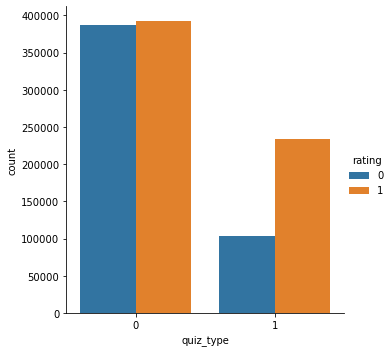

In [15]:
sns.catplot('quiz_type',data=df, hue='rating',kind='count')

In [56]:
# Convert categorical value to numeric value 
df['quiz_type'] = df.quiz_type.map({'random':0, 'personalized':1})
df.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
0,0,0,0,0,45,1
1,0,0,0,1,734,1
2,0,0,0,2,4145,1
3,0,0,0,3,3231,0
4,0,0,0,4,361,1


#### Item_ID

In [17]:
# There are 5000 unique items appeared on the quizzes. On average, an item appeared 223 times. Considering the size of the dataset, the cardinality of item isn't too large
df['item_id'].nunique()

5000

In [18]:
# The top 10 most appeared items on the quizzes. The range of items is quite compact 
df.groupby('item_id').size().sort_values(ascending=False)[:10]

item_id
1279    406
1540    403
1253    400
2582    395
3531    394
3414    393
3089    393
3188    391
515     391
409     391
dtype: int64

In [19]:
# The top 20 items that appeared on the quiz all received "Likes"; In fact, the item with the most "Dislikes" received, appears after the 200th. 
df.groupby(['item_id','rating'])['rating'].count().sort_values(ascending=False)[:20]

item_id  rating
2580     1         361
4195     1         358
3314     1         352
3531     1         349
859      1         345
1279     1         345
1540     1         345
1885     1         344
1374     1         343
4029     1         342
2728     1         341
4702     1         341
387      1         341
3217     1         341
4828     1         340
1253     1         339
4567     1         337
1970     1         336
3089     1         335
3153     1         335
Name: rating, dtype: int64

### EDA in Visualization

##### Quiz Type across Quiz Number

(0.0, 30.0)

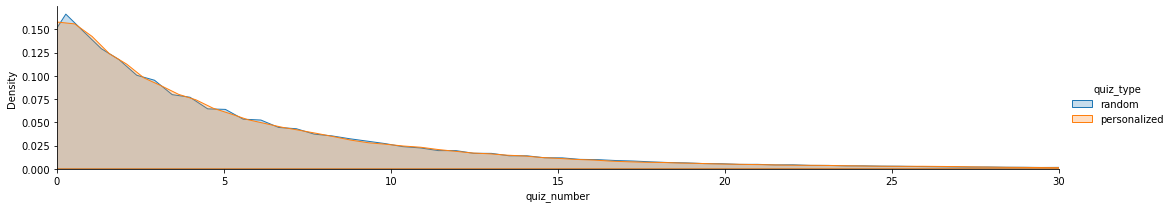

In [55]:
as_fig = sns.FacetGrid(df,hue='quiz_type',aspect=5)
as_fig.map(sns.kdeplot,'quiz_number',shade=True)
as_fig.add_legend()
plt.xlim(0,30)

##### Observation : 
- Both personalized and random quizzes show a very similar exponential slide trend along the sequence of quizzes
- Both quiz types reach to 1/6 reduction point (from 0) around the 9th quiz.
- Thus, we deem that "quiz type" may not affect the level of interest in interaction with the quiz

##### Rating accross Quiz Number

(0.0, 15.0)

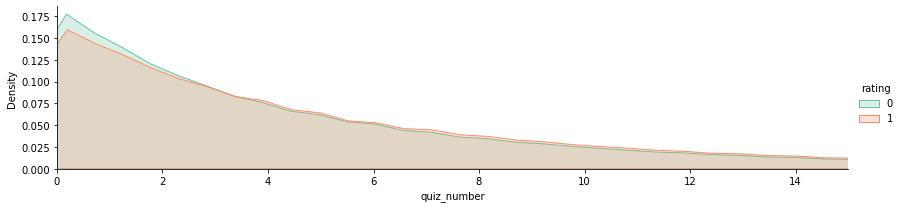

In [23]:
as_fig = sns.FacetGrid(df,hue='rating',aspect=4, palette= "Set2")
as_fig.map(sns.kdeplot,'quiz_number',shade=True)
as_fig.add_legend()
plt.xlim(0,15)

##### Observation :
- Up to 2nd quiz, there is a noticeable difference between "Like" and "Dislike" clicks. At the very first quiz, "Likes" garnered around 10% more clicks than "Dislikes".
-  We can notice that there is a pointy peak at the beginning of quiz number 0. It is also the point where the gap between "Dislike" and "Like" is the largest.

#### Q) In which question number, the gap between "Likes" and "Dislike" is widened? 

(0.0, 20.0)

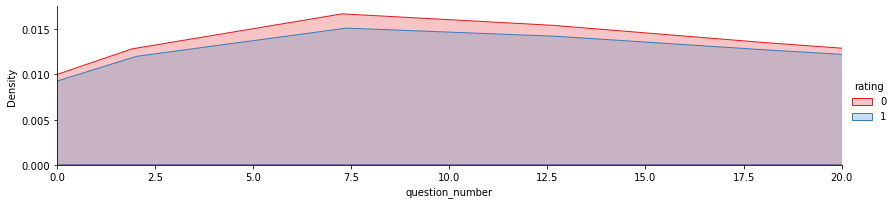

In [24]:
as_fig = sns.FacetGrid(df,hue='rating',aspect=4, palette= "Set1")
as_fig.map(sns.kdeplot,'question_number',shade=True)
as_fig.add_legend()
plt.xlim(0,20)

##### Observation : 
- Around the 7th and 8th question number, user interaction frequency peaks at its high, as well as the gap between "Dislikes" and "Likes". This is the most critical section that the company should exert a better algorithm to display items that are relevant to the taste of users that promotes more engaging interaction by the users.

## Recommender System Modeling 
**Collaborative Filtering** It is a popular Recommender System (RecSYs) technique that makes automatic predictions (filtering) about the interest of a user by collecting preferences or taste information from other users' previous experiences (collaborating). 

In the case of this project, the model makes predictions about a user's potentially preferable clothes based on other similar users' demonstration of taste throughout the quizzes. 

The underlying assumption of the collaborative filtering approach is that if Jonn has the same/similar taste as David on a set of items, John is more likely to have David's taste for a given item than that of other randomly chosen people randomly chosen person. 

### Collaborative Filtering
##### (K-Nearest Neighborhood)  

The standard method of Collaborative Filtering is known as Nearest Neighborhood algorithm. There are user-based CF and item-based CF. Here, in this project, we will focus on item-based CF.

To make a new recommendation to a user, the idea of item-based method is to find items similar to the ones the user already "positively" interacted with, or "Like" rating. Two items are considered to be similar if most of the users that have interest in both of them did it in a similar way. 

This item-centered method is based on interactions users had with them and evaluating distances between those items. 

- To ensure statistical significance, we will focus on items with a high appearance on the quiz.
- In order to find out which items appeared most often, we need to create a column that counts rating or frequency of appearance of item

In [25]:
df_rating = pd.DataFrame({'Count_of_Rating':df.groupby('item_id').count()['rating'], "Mean_Rating":df.groupby('item_id').mean()['rating']})

In [26]:
df_new = df_rating.merge(df, left_on ='item_id', right_on='item_id')

In [27]:
df_new.head()

,item_id,Count_of_Rating,Mean_Rating,user_id,quiz_type,quiz_number,question_number,rating
0,0,163,0.466258,167,NaN,7,76,0
1,0,163,0.466258,259,NaN,1,12,1
2,0,163,0.466258,350,NaN,3,31,0
3,0,163,0.466258,395,NaN,1,12,0
4,0,163,0.466258,972,NaN,8,83,1


In [28]:
# The range of count of rating across items is quite compact, however, focusing on items with a high appearnce may increase accuracy
df_rating['Count_of_Rating'].describe()

count    5000.000000
mean      223.274000
std        71.209091
min       119.000000
25%       164.000000
50%       195.000000
75%       281.000000
max       406.000000
Name: Count_of_Rating, dtype: float64

- Although the size of the dataset is big (over one million), there are only 5000 distinct items so we cannot eliminate the majority of the items. 
- We will keep about 25% of items, which sets the lower-bound threshold at 281 frequency of rating, this will give us 1250 unique items.

In [29]:
df_rating['Count_of_Rating'].quantile(np.arange(0.75,1,.01)).head()

0.75    281.0
0.76    285.0
0.77    289.0
0.78    294.0
0.79    297.0
Name: Count_of_Rating, dtype: float64

In [30]:
threshold = 281
df_popular_rating = df_new.query('Count_of_Rating >= @threshold')
df_popular_rating.head()

,item_id,Count_of_Rating,Mean_Rating,user_id,quiz_type,quiz_number,question_number,rating
840,5,312,0.647436,35,NaN,4,45,0
841,5,312,0.647436,93,NaN,10,106,1
842,5,312,0.647436,367,NaN,0,1,1
843,5,312,0.647436,418,NaN,14,140,1
844,5,312,0.647436,441,NaN,0,2,0


In [31]:
df_popular_rating.shape

(412833, 8)

##### Implementing KNN

I will convert the table to a 2D matrix using pivot_table, and fill the missing values with zeros (since I will focusing on calculating the distances between rating vectors). 

Then, I will transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations, given that the dataframe contains a large number of zero-valued elements

In [32]:
df_pivot_rating = pd.pivot_table(data = df_popular_rating, index ='item_id', columns = 'user_id', values ='rating').fillna(value=0)

The algorithm  that  we rely on to compute the nearest neighbors is “brute”, the simplest among KNN algorithms, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors, and then, we fit the model

In [33]:
df_matrix_rating = csr_matrix(df_pivot_rating.values)

In [34]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm ='brute')
model_knn.fit(df_matrix_rating)

NearestNeighbors(algorithm='brute', metric='cosine')

Now, the kNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In the action, the query system automatically generated an item_id, 2449, and identified 5 items that (I set it in "n_neighbor) are in its nearest neighbors.

In [35]:
query_index = np.random.choice(df_pivot_rating.shape[0])
distances, indices = model_knn.kneighbors(df_pivot_rating.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendatoins for {0}:\n'.format(df_pivot_rating.index[query_index])) 
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_pivot_rating.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendatoins for 2449:

1: 4200, with distance of 0.9259187804019549:
2: 1717, with distance of 0.9373273777914962:
3: 2644, with distance of 0.9394635709034005:
4: 4281, with distance of 0.9401496512624673:
5: 3421, with distance of 0.9404229696968824:


Finally, we can recommend these five items with the closest distance to item 2449 to the users that have clicked "Likes" to 2449

In [36]:
df.groupby("item_id").get_group(2449).groupby(['user_id','item_id']).count()['rating']

user_id  item_id
126      2449       1
248      2449       1
413      2449       1
562      2449       1
655      2449       1
                   ..
19681    2449       1
19753    2449       1
19825    2449       1
19951    2449       1
19974    2449       1
Name: rating, Length: 316, dtype: int64

### Collaborative Filtering 

##### (Sigular Value Decomposition or SVD)

SVD is a powerful model for creating a Recommender System. Matrix Factorization, the idea behind SVD represents users and items in a lower-dimensional latent space and allows users to discover the latent features underlying the interactions between users and items.  


Just like in KNN, we start with converting the dataset into a 2D Matrix and fill the missing value with zeros

In [37]:
df_pivot_rating2 = pd.pivot_table(data = df_new, index ='user_id', columns = 'item_id', values ='rating').fillna(value=0)

In [38]:
df_pivot_rating2

item_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_pivot_rating2.shape

(20000, 5000)

In [40]:
df_pivot_rating.shape

(1252, 19835)

Now, we transpose this matrix for quick calculation in SVD. As result,the Item_ids become rows and User Ids become columns. After using TruncatedSVD to decompose it, we fit it into the model for dimensionality reduction. This compression happened on the dataframe’s columns since we  must preserve the Item_id. 

In the parameter, we can set n_components, we set it for 15, which means just 15 latent variables, and you can see, the data’s dimensions have been reduced significantly from 20000 X 5000 to 5000 X 15, as we fit it into the model.

In [41]:
X =df_pivot_rating2.values.T
X.shape

(5000, 20000)

In [42]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
SVD = TruncatedSVD(n_components=15)
matrix = SVD.fit_transform(X)
matrix.shape

(5000, 15)

After fitting and having done wtih dimensionality reduction. We calculate the Pearson's R correlation coefficient for every item pair in the final matrix. 


To compare this with the results from KNN, we pick the same item_id (2449) to find the items that have high correlation coefficients (between 0.91 and 1.0) with it.

In [44]:
correlation_matrix = np.corrcoef(matrix)
correlation_matrix.shape

(5000, 5000)

In [46]:
item_num = df_pivot_rating2.columns
item_list = list(item_num)
random_item = item_list.index(2449)
print(random_item)

2449


 Here are 7 items that have high correlation coefficients (between 0.91 to 1.0) with item 2449

In [53]:
corr_random_item = correlation_matrix[random_item]
list(item_num[(corr_random_item<1.0)&(corr_random_item>0.91)])

[1010, 1531, 1748, 1775, 2615, 4125, 4291]

### Areas to explore further

For a limit on time (2 hours), I didn't explore my initial presumption, the existence of users that engage in quizzes with an unfaithful or insincere attitude such as giving a barrage of "Likes" or "Dislikes" without consideration.

I may need to review the possible unusually high frequency of "Likes" or "Dislikes" from certain users. If there is a column tracking the time that users spent to rate each question, it may serve to identify those unfaithful and insincere ratings.

